## General description <a name="general_description"></a>


## Install and import necessary packages


In [1]:
import os
import re

import numpy as np
import pandas as pd
import sklearn.preprocessing

import geopy.distance

import catboost as cb

import xgboost as xgb
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


ModuleNotFoundError: No module named 'geopy'

## Load data


In [2]:
kaggle_data_name = 'covid19-global-forecasting-week-1'
data_folder = os.path.join(os.getcwd(), 'datasets', kaggle_data_name)

In [3]:
original_train_df = pd.read_csv(os.path.join(data_folder,'train.csv'), parse_dates=['Date'])

original_train_df.head()

Data loaded: unknown shape


,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


In [4]:
original_test_df = pd.read_csv(os.path.join(data_folder,'test.csv'), parse_dates=['Date'])

original_test_df.head()

Data loaded: unknown shape


,ForecastId,Province/State,Country/Region,Lat,Long,Date
0,1,NaN,Afghanistan,33.0,65.0,2020-03-12
1,2,NaN,Afghanistan,33.0,65.0,2020-03-13
2,3,NaN,Afghanistan,33.0,65.0,2020-03-14
3,4,NaN,Afghanistan,33.0,65.0,2020-03-15
4,5,NaN,Afghanistan,33.0,65.0,2020-03-16


In [5]:
last_original_train_date = original_train_df['Date'].max()
print ('last_original_train_date = ', last_original_train_date)

print ('original_test_df.shape =', original_test_df.shape)

original_test_wo_train_df = original_test_df.drop(
    index=original_test_df[original_test_df['Date'] <= last_original_train_date].index
)

print ('original_test_wo_train_df.shape =', original_test_wo_train_df.shape)

# recreate index bacause we will need unique index values later 
main_df = pd.concat([original_train_df, original_test_wo_train_df], ignore_index=True)

last_original_train_date =  2020-03-24 00:00:00
original_test_df.shape = (12212, 6)
original_test_wo_train_df.shape = (8520, 6)


In [6]:
from_cruise_ships = main_df['Province/State'].isin(['From Diamond Princess', 'Grand Princess'])
main_df.loc[from_cruise_ships, ['Province/State','Country/Region']] = main_df.loc[from_cruise_ships, ['Country/Region','Province/State']].values
main_df[main_df['Country/Region'].isin(['From Diamond Princess', 'Grand Princess'])]

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId
567,838.0,Australia,From Diamond Princess,35.4437,139.6380,2020-01-22,0.0,0.0,NaN
568,839.0,Australia,From Diamond Princess,35.4437,139.6380,2020-01-23,0.0,0.0,NaN
569,840.0,Australia,From Diamond Princess,35.4437,139.6380,2020-01-24,0.0,0.0,NaN
570,841.0,Australia,From Diamond Princess,35.4437,139.6380,2020-01-25,0.0,0.0,NaN
571,842.0,Australia,From Diamond Princess,35.4437,139.6380,2020-01-26,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...
24697,NaN,US,Grand Princess,37.6489,-122.6655,2020-04-19,NaN,NaN,9757.0
24698,NaN,US,Grand Princess,37.6489,-122.6655,2020-04-20,NaN,NaN,9758.0
24699,NaN,US,Grand Princess,37.6489,-122.6655,2020-04-21,NaN,NaN,9759.0
24700,NaN,US,Grand Princess,37.6489,-122.6655,2020-04-22,NaN,NaN,9760.0


## Feature engineering <a name="features"></a>
### Time delay embedding features <a name="time_delay_embedding_features"></a>


In [7]:
main_df.sort_values(by='Date', inplace=True)

location_columns = ['Country/Region','Province/State']

# row selection functions in pandas do not like nans
for column in location_columns:
    main_df[column].fillna('', inplace=True)


days_history_size = 30


def is_cumulative(increment_series):
    for v in increment_series:
        if (not np.isnan(v)) and (v < 0):
            return False
    return True

print ('data size before removing bad data = ', len(main_df))

for field in ['LogNewConfirmedCases', 'LogNewFatalities']:
    main_df[field] = np.nan

    for prev_day in range(1, days_history_size + 1):
        main_df[field + '_prev_day_%s' % prev_day] = np.nan


for location_name, location_df in main_df.groupby(['Country/Region', 'Province/State']):
    for field in ['ConfirmedCases', 'Fatalities']:
        new_values = location_df[field].values
        new_values[1:] -= new_values[:-1]
        if not is_cumulative(new_values):
            print ('%s for %s, %s is not valid cumulative series, drop it' % ((field,) + location_name))
            main_df.drop(index=location_df.index, inplace=True)
            break
        log_new_values = np.log1p(new_values)
        main_df.loc[location_df.index, 'LogNew' + field] = log_new_values

        for prev_day in range(1, days_history_size + 1):
            main_df.loc[location_df.index[prev_day:], 'LogNew%s_prev_day_%s' % (field, prev_day)] = (
                log_new_values[:-prev_day]
            )

print ('data size after removing bad data = ', len(main_df))
main_df.head()

data size before removing bad data =  26412


C:\Users\kkoh\AppData\Local\Temp\ipykernel_16520\1757444441.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  main_df[column].fillna('', inplace=True)


ConfirmedCases for Australia, Northern Territory is not valid cumulative series, drop it
ConfirmedCases for Australia, Queensland is not valid cumulative series, drop it
ConfirmedCases for Azerbaijan,  is not valid cumulative series, drop it
ConfirmedCases for Bahrain,  is not valid cumulative series, drop it
Fatalities for Canada, Quebec is not valid cumulative series, drop it
ConfirmedCases for China, Guizhou is not valid cumulative series, drop it
ConfirmedCases for France, France is not valid cumulative series, drop it
ConfirmedCases for France, Saint Barthelemy is not valid cumulative series, drop it
ConfirmedCases for Grand Princess, US is not valid cumulative series, drop it
ConfirmedCases for Guyana,  is not valid cumulative series, drop it
Fatalities for Iceland,  is not valid cumulative series, drop it
Fatalities for India,  is not valid cumulative series, drop it
ConfirmedCases for Japan,  is not valid cumulative series, drop it
Fatalities for Kazakhstan,  is not valid cumul

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,LogNewConfirmedCases,...,LogNewFatalities_prev_day_21,LogNewFatalities_prev_day_22,LogNewFatalities_prev_day_23,LogNewFatalities_prev_day_24,LogNewFatalities_prev_day_25,LogNewFatalities_prev_day_26,LogNewFatalities_prev_day_27,LogNewFatalities_prev_day_28,LogNewFatalities_prev_day_29,LogNewFatalities_prev_day_30
0,1.0,,Afghanistan,33.0000,65.0000,2020-01-22,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5544,8185.0,,Cyprus,35.1264,33.4299,2020-01-22,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14301,21112.0,Guam,US,13.4443,144.7937,2020-01-22,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5607,8278.0,,Czechia,49.8175,15.4730,2020-01-22,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5670,8371.0,Denmark,Denmark,56.2639,9.5018,2020-01-22,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Day feature


In [8]:
first_date = min(main_df['Date'])
    
main_df['Day'] = (main_df['Date'] - first_date).dt.days.astype('int32')

### WeekDay feature


In [9]:
main_df['WeekDay'] = main_df['Date'].transform(lambda d: d.weekday())

### Days since Xth Confirmed case and Xth Fatality features


In [10]:
thresholds = [1, 10, 100]

for threshold in thresholds:
    main_df['Days_since_ConfirmedCases=%s' % threshold] = np.nan
    main_df['Days_since_Fatalities=%s' % threshold] = np.nan

for location_name, location_df in main_df.groupby(['Country/Region', 'Province/State']):
    for field in ['ConfirmedCases', 'Fatalities']:
        for threshold in thresholds:
            first_day = location_df['Day'].loc[location_df[field] >= threshold].min()
            if not np.isnan(first_day):
                main_df.loc[location_df.index, 'Days_since_%s=%s' % (field, threshold)] = (
                    location_df['Day'].transform(lambda day: -1 if (day < first_day) else (day - first_day))
                )

### 'Distance to Origin' feature.


In [11]:
def get_hubei_coords(df):
    for index, row in df.iterrows():
        if row['Province/State'] == 'Hubei':
            return (row['Lat'], row['Long'])

    raise Exception('Hubei not found in data')


origin_coords = get_hubei_coords(main_df)

main_df['Distance_to_origin'] = main_df.apply(
    lambda row: geopy.distance.distance((row['Lat'], row['Long']), origin_coords).km,
    axis='columns'
)


### Functions for merging external data 


In [ ]:
def merge_with_column_drop(left_df, right_df, right_df_column='Country'):
    df = pd.merge(
        left=left_df,
        right=right_df,
        how='left',
        left_on='Country/Region',
        right_on=right_df_column
    )
    df.drop(columns=right_df_column, inplace=True)
    
    return df

def remap_country_name_from_world_bank_to_main_df_name(country):
    return {
        'Bahamas, The': 'The Bahamas',
        'Brunei Darussalam': 'Brunei',
        'Congo, Rep.': 'Congo (Brazzaville)',
        'Congo, Dem. Rep.': 'Congo (Kinshasa)',
        'Czech Republic': 'Czechia',
        'Egypt, Arab Rep.': 'Egypt',
        'Iran, Islamic Rep.': 'Iran',
        'Korea, Rep.': 'Korea, South',
        'Kyrgyz Republic': 'Kyrgyzstan',
        'Russian Federation': 'Russia',
        'Slovak Republic': 'Slovakia',
        'St. Lucia': 'Saint Lucia',
        'St. Vincent and the Grenadines': 'Saint Vincent and the Grenadines',
        'United States': 'US',
        'Venezuela, RB': 'Venezuela',
    }.get(country, country)

def remap_country_name_from_un_wpp_to_main_df_name(country):
    return {
        'Bahamas': 'The Bahamas',
        'Bolivia (Plurinational State of)': 'Bolivia',
        'Brunei Darussalam': 'Brunei',
        'China, Taiwan Province of China': 'Taiwan*',
        'Congo' : 'Congo (Brazzaville)',
        'Côte d\'Ivoire': 'Cote d\'Ivoire',
        'Democratic Republic of the Congo': 'Congo (Kinshasa)',
        'Gambia': 'The Gambia',
        'Iran (Islamic Republic of)': 'Iran',
        'Republic of Korea': 'Korea, South',
        'Republic of Moldova': 'Moldova',
        'Réunion': 'Reunion',
        'Russian Federation': 'Russia',
        'United Republic of Tanzania': 'Tanzania',
        'United States of America': 'US',
        'Venezuela (Bolivarian Republic of)': 'Venezuela',
        'Viet Nam': 'Vietnam'
    }.get(country, country)

# for read_csv

world_bank_converters={'Country Name': remap_country_name_from_world_bank_to_main_df_name}
un_wpp_converters={'Location': remap_country_name_from_un_wpp_to_main_df_name}

Data loaded: unknown shape


### Country Area


In [13]:
import os
import urllib.request
import zipfile

# Create directory if it doesn't exist
area_dir = 'area'
os.makedirs(area_dir, exist_ok=True)
os.chdir(area_dir)

# Download the file if it doesn't exist
url = 'http://api.worldbank.org/v2/en/indicator/AG.LND.TOTL.K2?downloadformat=csv'
zip_filename = 'area.zip'
if not os.path.exists(zip_filename):
    urllib.request.urlretrieve(url, zip_filename)
    print(f"Downloaded {zip_filename}")
else:
    print(f"{zip_filename} already exists, skipping download.")

# Unzip without overwriting existing files
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if not os.path.exists(file):
            zip_ref.extract(file)
            print(f"Extracted: {file}")
        else:
            print(f"Skipped (already exists): {file}")

# List contents of current directory
print("Directory contents:")
for file in os.listdir('.'):
    print(file)


area.zip already exists, skipping download.
Skipped (already exists): Metadata_Indicator_API_AG.LND.TOTL.K2_DS2_en_csv_v2_21556.csv
Skipped (already exists): API_AG.LND.TOTL.K2_DS2_en_csv_v2_21556.csv
Skipped (already exists): Metadata_Country_API_AG.LND.TOTL.K2_DS2_en_csv_v2_21556.csv
Directory contents:
API_AG.LND.TOTL.K2_DS2_en_csv_v2_21556.csv
area.zip
Metadata_Country_API_AG.LND.TOTL.K2_DS2_en_csv_v2_21556.csv
Metadata_Indicator_API_AG.LND.TOTL.K2_DS2_en_csv_v2_21556.csv


In [14]:
area_df = pd.read_csv('./API_AG.LND.TOTL.K2_DS2_en_csv_v2_21556.csv', skiprows=4, converters=world_bank_converters)

os.chdir('..')
area_df.head()

Data loaded: unknown shape


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,Land area (sq. km),AG.LND.TOTL.K2,NaN,180.0,180.0,180.0,180.0,180.0,...,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Land area (sq. km),AG.LND.TOTL.K2,NaN,11094611.0,11094611.0,11094611.0,11094611.0,11094611.0,...,1.484511e+07,1.484510e+07,1.484512e+07,1.484513e+07,1.484509e+07,1.484509e+07,1.484509e+07,NaN,NaN,NaN
2,Afghanistan,AFG,Land area (sq. km),AG.LND.TOTL.K2,NaN,652230.0,652230.0,652230.0,652230.0,652230.0,...,6.522300e+05,6.522300e+05,6.522300e+05,6.522300e+05,6.522300e+05,6.522300e+05,6.522300e+05,NaN,NaN,NaN
3,Africa Western and Central,AFW,Land area (sq. km),AG.LND.TOTL.K2,NaN,9046580.0,9046580.0,9046580.0,9046580.0,9046580.0,...,9.045780e+06,9.045780e+06,9.045780e+06,9.045773e+06,9.045770e+06,9.045773e+06,9.045773e+06,NaN,NaN,NaN
4,Angola,AGO,Land area (sq. km),AG.LND.TOTL.K2,NaN,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,...,1.246700e+06,1.246700e+06,1.246700e+06,1.246700e+06,1.246700e+06,1.246700e+06,1.246700e+06,NaN,NaN,NaN


In [15]:
year_columns = [str(year) for year in range(1960, 2020)]

area_df['CountryArea'] = area_df[year_columns].apply(
    lambda row: row[row.last_valid_index()] if row.last_valid_index() else np.nan,
    axis='columns'    
)

In [16]:
area_df = area_df[['Country Name', 'CountryArea']]
area_df.head()

,Country Name,CountryArea
0,Aruba,1.800000e+02
1,Africa Eastern and Southern,1.484513e+07
2,Afghanistan,6.522300e+05
3,Africa Western and Central,9.045773e+06
4,Angola,1.246700e+06


In [17]:
main_df = merge_with_column_drop(
    main_df,
    area_df,
    right_df_column='Country Name'
)
main_df.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,LogNewConfirmedCases,...,Day,WeekDay,Days_since_ConfirmedCases=1,Days_since_Fatalities=1,Days_since_ConfirmedCases=10,Days_since_Fatalities=10,Days_since_ConfirmedCases=100,Days_since_Fatalities=100,Distance_to_origin,CountryArea
0,1.0,,Afghanistan,33.0000,65.0000,2020-01-22,0.0,0.0,NaN,0.0,...,0,2,-1.0,-1.0,-1.0,NaN,NaN,NaN,4435.232618,652230.0
1,8185.0,,Cyprus,35.1264,33.4299,2020-01-22,0.0,0.0,NaN,0.0,...,0,2,-1.0,-1.0,-1.0,NaN,-1.0,NaN,7177.529195,9240.0
2,21112.0,Guam,US,13.4443,144.7937,2020-01-22,0.0,0.0,NaN,0.0,...,0,2,-1.0,-1.0,-1.0,NaN,NaN,NaN,3851.942689,9147420.0
3,8278.0,,Czechia,49.8175,15.4730,2020-01-22,0.0,0.0,NaN,0.0,...,0,2,NaN,NaN,NaN,NaN,NaN,NaN,7897.624038,77205.5
4,8371.0,Denmark,Denmark,56.2639,9.5018,2020-01-22,0.0,0.0,NaN,0.0,...,0,2,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,7931.069186,40000.0


### Country population features


In [18]:

population_df = pd.read_csv(
    'datasets/WPP2019_PopulationByAgeSex_Medium.csv',
     usecols=['Location', 'Time', 'AgeGrp', 'PopMale', 'PopFemale', 'PopTotal'],
    parse_dates=['Time'],
    converters=un_wpp_converters
)
population_df.head()

,Location,Time,AgeGrp,PopMale,PopFemale,PopTotal
0,Afghanistan,1950-01-01,0-4,630.044,661.578,1291.622
1,Afghanistan,1950-01-01,5-9,516.206,487.335,1003.541
2,Afghanistan,1950-01-01,10-14,461.378,423.326,884.704
3,Afghanistan,1950-01-01,15-19,414.369,369.363,783.732
4,Afghanistan,1950-01-01,20-24,374.109,318.392,692.501


In [19]:
population_df = population_df.loc[
    (population_df['Time'] >= pd.Timestamp(2014,1,1))
    & (population_df['Time'] <= pd.Timestamp(2019,1,1))
]
population_df.head()

,Location,Time,AgeGrp,PopMale,PopFemale,PopTotal
1344,Afghanistan,2014-01-01,0-4,2803.677,2671.583,5475.260
1345,Afghanistan,2014-01-01,5-9,2635.812,2520.840,5156.652
1346,Afghanistan,2014-01-01,10-14,2356.524,2242.185,4598.709
1347,Afghanistan,2014-01-01,15-19,1995.824,1894.380,3890.204
1348,Afghanistan,2014-01-01,20-24,1580.881,1458.199,3039.080


In [ ]:
aggregated_population_df = pd.DataFrame()

for (location, time), group_df in population_df.groupby(["Location", "Time"]):
    # by ['Pop_0-20', 'Pop_20-40', 'Pop_40-60', 'Pop_60-80', 'Pop_80+']
    pop_by_age_groups = [0] * 5

    pop_male = 0
    pop_female = 0

    for _, row in group_df.iterrows():
        age_grp_start = int(re.split(r"[\-\+]", row["AgeGrp"])[0])
        pop_by_age_groups[min(age_grp_start // 20, 4)] += (
            row["PopMale"] + row["PopFemale"]
        )
        pop_male += row["PopMale"]
        pop_female += row["PopFemale"]

        print(
            {
                "Location": location,
                "Time": time,
                "CountryPop_0-20": pop_by_age_groups[0],
                "CountryPop_20-40": pop_by_age_groups[1],
                "CountryPop_40-60": pop_by_age_groups[2],
                "CountryPop_60-80": pop_by_age_groups[3],
                "CountryPop_80+": pop_by_age_groups[4],
                "CountryPopMale": pop_male,
                "CountryPopFemale": pop_female,
                "CountryPopTotal": pop_male + pop_female,
            }
        )
    aggregated_population_df = aggregated_population_df.append(
        {
            "Location": location,
            "Time": time,
            "CountryPop_0-20": pop_by_age_groups[0],
            "CountryPop_20-40": pop_by_age_groups[1],
            "CountryPop_40-60": pop_by_age_groups[2],
            "CountryPop_60-80": pop_by_age_groups[3],
            "CountryPop_80+": pop_by_age_groups[4],
            "CountryPopMale": pop_male,
            "CountryPopFemale": pop_female,
            "CountryPopTotal": pop_male + pop_female,
        },
        ignore_index=True,
    )

aggregated_population_df.head()

In [22]:
aggregated_population_df = aggregated_population_df.sort_values('Time').drop_duplicates(['Location'], keep='last')
aggregated_population_df.head()

,Location,Time,CountryPop_0-20,CountryPop_20-40,CountryPop_40-60,CountryPop_60-80,CountryPop_80+,CountryPopMale,CountryPopFemale,CountryPopTotal
2417,United Kingdom,2019-01-01,15634.443,17834.183,17763.044,12879.932,3418.559,33351.435,34178.726,67530.161
2519,WB region: Middle East and North Africa (exclu...,2019-01-01,153429.571,127412.450,75929.068,29424.842,3557.260,196415.223,193337.968,389753.191
2375,UNICEF Regions: West and Central Africa,2019-01-01,290642.723,149895.255,69210.044,22655.758,1519.495,268213.492,265709.783,533923.275
2627,Yemen,2019-01-01,14585.766,9617.139,3621.970,1236.095,100.952,14692.284,14469.638,29161.922
2633,Zambia,2019-01-01,9995.380,5186.638,2074.569,559.205,45.242,8843.214,9017.820,17861.034


In [23]:
aggregated_population_df.drop(columns='Time', inplace=True)

main_df = merge_with_column_drop(
    main_df,
    aggregated_population_df,
    right_df_column='Location'
)
main_df.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,LogNewConfirmedCases,...,Distance_to_origin,CountryArea,CountryPop_0-20,CountryPop_20-40,CountryPop_40-60,CountryPop_60-80,CountryPop_80+,CountryPopMale,CountryPopFemale,CountryPopTotal
0,1.0,,Afghanistan,33.0000,65.0000,2020-01-22,0.0,0.0,NaN,0.0,...,4435.232618,652230.0,20676.365,11160.511,4620.268,1479.526,105.087,19529.727,18512.030,38041.757
1,8185.0,,Cyprus,35.1264,33.4299,2020-01-22,0.0,0.0,NaN,0.0,...,7177.529195,9240.0,275.284,382.653,308.911,193.202,38.524,599.297,599.277,1198.574
2,21112.0,Guam,US,13.4443,144.7937,2020-01-22,0.0,0.0,NaN,0.0,...,3851.942689,9147420.0,82289.916,90159.134,82846.126,60854.332,12915.409,162826.299,166238.618,329064.917
3,8278.0,,Czechia,49.8175,15.4730,2020-01-22,0.0,0.0,NaN,0.0,...,7897.624038,77205.5,2152.923,2656.340,3107.360,2332.215,440.375,5260.628,5428.585,10689.213
4,8371.0,Denmark,Denmark,56.2639,9.5018,2020-01-22,0.0,0.0,NaN,0.0,...,7931.069186,40000.0,1287.864,1437.566,1556.036,1224.130,266.281,2869.672,2902.205,5771.877


### Country Population density feature


In [24]:
main_df['CountryPopDensity'] = main_df['CountryPopTotal'] / main_df['CountryArea']

### Country Smoking rate feature


In [25]:
import os
import urllib.request
import zipfile

# Create directory and change into it
smoking_dir = 'smoking'
os.makedirs(smoking_dir, exist_ok=True)
os.chdir(smoking_dir)

# Define download URL and filename
url = 'http://api.worldbank.org/v2/en/indicator/SH.PRV.SMOK?downloadformat=csv'
zip_filename = 'smoking.zip'

# Download the file if it doesn't already exist
if not os.path.exists(zip_filename):
    print("Downloading...")
    urllib.request.urlretrieve(url, zip_filename)
    print("Download complete.")
else:
    print("Zip file already exists, skipping download.")

# Unzip without overwriting existing files
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if not os.path.exists(file):
            zip_ref.extract(file)
            print(f"Extracted: {file}")
        else:
            print(f"Skipped (already exists): {file}")

# List directory contents
print("Directory contents:")
for fname in os.listdir('.'):
    print(fname)


Zip file already exists, skipping download.
Skipped (already exists): Metadata_Indicator_API_SH.PRV.SMOK_DS2_en_csv_v2_31160.csv
Skipped (already exists): API_SH.PRV.SMOK_DS2_en_csv_v2_31160.csv
Skipped (already exists): Metadata_Country_API_SH.PRV.SMOK_DS2_en_csv_v2_31160.csv
Directory contents:
API_SH.PRV.SMOK_DS2_en_csv_v2_31160.csv
Metadata_Country_API_SH.PRV.SMOK_DS2_en_csv_v2_31160.csv
Metadata_Indicator_API_SH.PRV.SMOK_DS2_en_csv_v2_31160.csv
smoking.zip


In [ ]:
smoking_df = pd.read_csv('./API_SH.PRV.SMOK_DS2_en_csv_v2_31160.csv', skiprows=4)

os.chdir('..')
smoking_df.head()

Data loaded: unknown shape


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,Prevalence of current tobacco use (% of adults),SH.PRV.SMOK,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Prevalence of current tobacco use (% of adults),SH.PRV.SMOK,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12.444895,12.160833,11.881951,NaN,NaN,NaN
2,Afghanistan,AFG,Prevalence of current tobacco use (% of adults),SH.PRV.SMOK,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,23.700000,23.200000,22.700000,NaN,NaN,NaN
3,Africa Western and Central,AFW,Prevalence of current tobacco use (% of adults),SH.PRV.SMOK,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.109380,5.889220,5.734154,NaN,NaN,NaN
4,Angola,AGO,Prevalence of current tobacco use (% of adults),SH.PRV.SMOK,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
recent_year_columns = [str(year) for year in range(2010, 2020)]

smoking_df['CountrySmokingRate'] = smoking_df[recent_year_columns].apply(
    lambda row: row[row.last_valid_index()] if row.last_valid_index() else np.nan,
    axis='columns'    
)

In [28]:
smoking_df = smoking_df[['Country Name', 'CountrySmokingRate']]
smoking_df.head()

,Country Name,CountrySmokingRate
0,Aruba,NaN
1,Africa Eastern and Southern,14.096160
2,Afghanistan,26.600000
3,Africa Western and Central,7.358627
4,Angola,NaN


In [29]:
main_df = merge_with_column_drop(
    main_df,
    smoking_df,
    right_df_column='Country Name'
)
main_df.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,LogNewConfirmedCases,...,CountryPop_0-20,CountryPop_20-40,CountryPop_40-60,CountryPop_60-80,CountryPop_80+,CountryPopMale,CountryPopFemale,CountryPopTotal,CountryPopDensity,CountrySmokingRate
0,1.0,,Afghanistan,33.0000,65.0000,2020-01-22,0.0,0.0,NaN,0.0,...,20676.365,11160.511,4620.268,1479.526,105.087,19529.727,18512.030,38041.757,0.058326,26.6
1,8185.0,,Cyprus,35.1264,33.4299,2020-01-22,0.0,0.0,NaN,0.0,...,275.284,382.653,308.911,193.202,38.524,599.297,599.277,1198.574,0.129716,37.1
2,21112.0,Guam,US,13.4443,144.7937,2020-01-22,0.0,0.0,NaN,0.0,...,82289.916,90159.134,82846.126,60854.332,12915.409,162826.299,166238.618,329064.917,0.035974,NaN
3,8278.0,,Czechia,49.8175,15.4730,2020-01-22,0.0,0.0,NaN,0.0,...,2152.923,2656.340,3107.360,2332.215,440.375,5260.628,5428.585,10689.213,0.138451,31.4
4,8371.0,Denmark,Denmark,56.2639,9.5018,2020-01-22,0.0,0.0,NaN,0.0,...,1287.864,1437.566,1556.036,1224.130,266.281,2869.672,2902.205,5771.877,0.144297,21.2


### Country hospital beds per 1000 people


In [30]:
import os
import urllib.request
import zipfile

# Create and enter directory
dir_name = 'hospital_beds'
os.makedirs(dir_name, exist_ok=True)
os.chdir(dir_name)

# Download URL and local filename
url = 'http://api.worldbank.org/v2/en/indicator/SH.MED.BEDS.ZS?downloadformat=csv'
zip_filename = 'hospital_beds.zip'

# Download file if not already downloaded
if not os.path.exists(zip_filename):
    print(f"Downloading {zip_filename}...")
    urllib.request.urlretrieve(url, zip_filename)
    print("Download complete.")
else:
    print(f"{zip_filename} already exists, skipping download.")

# Extract files without overwriting
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if not os.path.exists(file):
            zip_ref.extract(file)
            print(f"Extracted: {file}")
        else:
            print(f"Skipped (already exists): {file}")

# List files
print("\nDirectory contents:")
for f in os.listdir('.'):
    print(f)


Download complete.
Extracted: Metadata_Indicator_API_SH.MED.BEDS.ZS_DS2_en_csv_v2_23583.csv
Extracted: API_SH.MED.BEDS.ZS_DS2_en_csv_v2_23583.csv
Extracted: Metadata_Country_API_SH.MED.BEDS.ZS_DS2_en_csv_v2_23583.csv

Directory contents:
API_SH.MED.BEDS.ZS_DS2_en_csv_v2_23583.csv
hospital_beds.zip
Metadata_Country_API_SH.MED.BEDS.ZS_DS2_en_csv_v2_23583.csv
Metadata_Indicator_API_SH.MED.BEDS.ZS_DS2_en_csv_v2_23583.csv


In [ ]:
hospital_beds_df = pd.read_csv('./API_SH.MED.BEDS.ZS_DS2_en_csv_v2_23583.csv', skiprows=4)

os.chdir('..')
hospital_beds_df.head()

Data loaded: unknown shape


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,1.973383,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,0.170627,NaN,NaN,NaN,NaN,NaN,...,0.45,0.42,0.4,0.38,0.34,0.36,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,0.786552,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,2.061462,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.75,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
recent_year_columns = [str(year) for year in range(2010, 2020)]

hospital_beds_df['CountryHospitalBedsRate'] = hospital_beds_df[recent_year_columns].apply(
    lambda row: row[row.last_valid_index()] if row.last_valid_index() else np.nan,
    axis='columns'    
)

In [33]:
hospital_beds_df = hospital_beds_df[['Country Name', 'CountryHospitalBedsRate']]
hospital_beds_df.head()

,Country Name,CountryHospitalBedsRate
0,Aruba,NaN
1,Africa Eastern and Southern,NaN
2,Afghanistan,0.38
3,Africa Western and Central,NaN
4,Angola,0.75


In [34]:
main_df = merge_with_column_drop(
    main_df,
    hospital_beds_df,
    right_df_column='Country Name'
)
main_df.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,LogNewConfirmedCases,...,CountryPop_20-40,CountryPop_40-60,CountryPop_60-80,CountryPop_80+,CountryPopMale,CountryPopFemale,CountryPopTotal,CountryPopDensity,CountrySmokingRate,CountryHospitalBedsRate
0,1.0,,Afghanistan,33.0000,65.0000,2020-01-22,0.0,0.0,NaN,0.0,...,11160.511,4620.268,1479.526,105.087,19529.727,18512.030,38041.757,0.058326,26.6,0.38
1,8185.0,,Cyprus,35.1264,33.4299,2020-01-22,0.0,0.0,NaN,0.0,...,382.653,308.911,193.202,38.524,599.297,599.277,1198.574,0.129716,37.1,2.24
2,21112.0,Guam,US,13.4443,144.7937,2020-01-22,0.0,0.0,NaN,0.0,...,90159.134,82846.126,60854.332,12915.409,162826.299,166238.618,329064.917,0.035974,NaN,NaN
3,8278.0,,Czechia,49.8175,15.4730,2020-01-22,0.0,0.0,NaN,0.0,...,2656.340,3107.360,2332.215,440.375,5260.628,5428.585,10689.213,0.138451,31.4,6.66
4,8371.0,Denmark,Denmark,56.2639,9.5018,2020-01-22,0.0,0.0,NaN,0.0,...,1437.566,1556.036,1224.130,266.281,2869.672,2902.205,5771.877,0.144297,21.2,2.60


### Country Health Expenditure


In [35]:
import os
import urllib.request
import zipfile

# Create and enter directory
dir_name = 'health_expenditure'
os.makedirs(dir_name, exist_ok=True)
os.chdir(dir_name)

# Define URL and output zip filename
url = 'http://api.worldbank.org/v2/en/indicator/SH.XPD.CHEX.PP.CD?downloadformat=csv'
zip_filename = 'health_expenditure.zip'

# Download the ZIP if not already present
if not os.path.exists(zip_filename):
    print(f"Downloading {zip_filename}...")
    urllib.request.urlretrieve(url, zip_filename)
    print("Download complete.")
else:
    print(f"{zip_filename} already exists, skipping download.")

# Extract files (skip if already extracted)
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if not os.path.exists(file):
            zip_ref.extract(file)
            print(f"Extracted: {file}")
        else:
            print(f"Skipped (already exists): {file}")

# List directory contents
print("\nDirectory contents:")
for fname in os.listdir('.'):
    print(fname)


Download complete.
Extracted: Metadata_Indicator_API_SH.XPD.CHEX.PP.CD_DS2_en_csv_v2_34418.csv
Extracted: API_SH.XPD.CHEX.PP.CD_DS2_en_csv_v2_34418.csv
Extracted: Metadata_Country_API_SH.XPD.CHEX.PP.CD_DS2_en_csv_v2_34418.csv

Directory contents:
API_SH.XPD.CHEX.PP.CD_DS2_en_csv_v2_34418.csv
health_expenditure.zip
Metadata_Country_API_SH.XPD.CHEX.PP.CD_DS2_en_csv_v2_34418.csv
Metadata_Indicator_API_SH.XPD.CHEX.PP.CD_DS2_en_csv_v2_34418.csv


In [ ]:
health_expenditure_df = pd.read_csv('./API_SH.XPD.CHEX.PP.CD_DS2_en_csv_v2_34418.csv', skiprows=4)

os.chdir('..')
health_expenditure_df.head()

Data loaded: unknown shape


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,"Current health expenditure per capita, PPP (cu...",SH.XPD.CHEX.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Current health expenditure per capita, PPP (cu...",SH.XPD.CHEX.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,214.970206,206.302251,203.618676,208.659981,209.392442,218.243527,228.081066,NaN,NaN,NaN
2,Afghanistan,AFG,"Current health expenditure per capita, PPP (cu...",SH.XPD.CHEX.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,238.744806,264.206606,299.372498,320.826992,324.667105,360.758388,383.107288,NaN,NaN,NaN
3,Africa Western and Central,AFW,"Current health expenditure per capita, PPP (cu...",SH.XPD.CHEX.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,150.421832,149.059208,135.274666,140.751044,160.185249,182.228794,200.892067,NaN,NaN,NaN
4,Angola,AGO,"Current health expenditure per capita, PPP (cu...",SH.XPD.CHEX.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,190.471975,201.261772,182.639950,173.056602,217.194974,213.965743,216.919254,NaN,NaN,NaN


In [39]:
recent_year_columns = [str(year) for year in range(2010, 2020)]

health_expenditure_df['CountryHealthExpenditurePerCapitaPPP'] = health_expenditure_df[recent_year_columns].apply(
    lambda row: row[row.last_valid_index()] if row.last_valid_index() else np.nan,
    axis='columns'    
)

In [40]:
health_expenditure_df = health_expenditure_df[['Country Name', 'CountryHealthExpenditurePerCapitaPPP']]
health_expenditure_df.head()

,Country Name,CountryHealthExpenditurePerCapitaPPP
0,Aruba,NaN
1,Africa Eastern and Southern,208.659981
2,Afghanistan,320.826992
3,Africa Western and Central,140.751044
4,Angola,173.056602


In [41]:
main_df = merge_with_column_drop(
    main_df,
    health_expenditure_df,
    right_df_column='Country Name'
)
main_df.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,LogNewConfirmedCases,...,CountryPop_40-60,CountryPop_60-80,CountryPop_80+,CountryPopMale,CountryPopFemale,CountryPopTotal,CountryPopDensity,CountrySmokingRate,CountryHospitalBedsRate,CountryHealthExpenditurePerCapitaPPP
0,1.0,,Afghanistan,33.0000,65.0000,2020-01-22,0.0,0.0,NaN,0.0,...,4620.268,1479.526,105.087,19529.727,18512.030,38041.757,0.058326,26.6,0.38,320.826992
1,8185.0,,Cyprus,35.1264,33.4299,2020-01-22,0.0,0.0,NaN,0.0,...,308.911,193.202,38.524,599.297,599.277,1198.574,0.129716,37.1,2.24,3179.284480
2,21112.0,Guam,US,13.4443,144.7937,2020-01-22,0.0,0.0,NaN,0.0,...,82846.126,60854.332,12915.409,162826.299,166238.618,329064.917,0.035974,NaN,NaN,NaN
3,8278.0,,Czechia,49.8175,15.4730,2020-01-22,0.0,0.0,NaN,0.0,...,3107.360,2332.215,440.375,5260.628,5428.585,10689.213,0.138451,31.4,6.66,3422.446589
4,8371.0,Denmark,Denmark,56.2639,9.5018,2020-01-22,0.0,0.0,NaN,0.0,...,1556.036,1224.130,266.281,2869.672,2902.205,5771.877,0.144297,21.2,2.60,6180.273429


## Prepare data for training


In [42]:
last_train_date = pd.Timestamp(2020, 3, 11)
last_eval_date = pd.Timestamp(2020, 3, 24)
last_test_date = pd.Timestamp(2020, 4, 23)

train_df = main_df[main_df['Date'] <= last_train_date].copy()
eval_df = main_df[(main_df['Date'] > last_train_date) & (main_df['Date'] <= last_eval_date)].copy()
test_df = main_df[main_df['Date'] > last_eval_date].copy()

# return features_df, labels
def preprocess_df(df):
    labels = df[['LogNewConfirmedCases', 'LogNewFatalities']].copy()
    features_df = df.drop(
        columns=['Id', 'ForecastId', 'ConfirmedCases', 'LogNewConfirmedCases', 'Fatalities', 'LogNewFatalities', 'Date']
    ).copy()
    
    return features_df, labels

train_features_df, train_labels = preprocess_df(train_df)
eval_features_df, eval_labels = preprocess_df(eval_df)
test_features_df, _ = preprocess_df(test_df)

In [43]:
train_features_df.head()

,Province/State,Country/Region,Lat,Long,LogNewConfirmedCases_prev_day_1,LogNewConfirmedCases_prev_day_2,LogNewConfirmedCases_prev_day_3,LogNewConfirmedCases_prev_day_4,LogNewConfirmedCases_prev_day_5,LogNewConfirmedCases_prev_day_6,...,CountryPop_40-60,CountryPop_60-80,CountryPop_80+,CountryPopMale,CountryPopFemale,CountryPopTotal,CountryPopDensity,CountrySmokingRate,CountryHospitalBedsRate,CountryHealthExpenditurePerCapitaPPP
0,,Afghanistan,33.0000,65.0000,NaN,NaN,NaN,NaN,NaN,NaN,...,4620.268,1479.526,105.087,19529.727,18512.030,38041.757,0.058326,26.6,0.38,320.826992
1,,Cyprus,35.1264,33.4299,NaN,NaN,NaN,NaN,NaN,NaN,...,308.911,193.202,38.524,599.297,599.277,1198.574,0.129716,37.1,2.24,3179.284480
2,Guam,US,13.4443,144.7937,NaN,NaN,NaN,NaN,NaN,NaN,...,82846.126,60854.332,12915.409,162826.299,166238.618,329064.917,0.035974,NaN,NaN,NaN
3,,Czechia,49.8175,15.4730,NaN,NaN,NaN,NaN,NaN,NaN,...,3107.360,2332.215,440.375,5260.628,5428.585,10689.213,0.138451,31.4,6.66,3422.446589
4,Denmark,Denmark,56.2639,9.5018,NaN,NaN,NaN,NaN,NaN,NaN,...,1556.036,1224.130,266.281,2869.672,2902.205,5771.877,0.144297,21.2,2.60,6180.273429


In [44]:
cat_features = ['Province/State', 'Country/Region']

## Models training


In [45]:
iterations = 1000

In [47]:
catboost_models = {}

for prediction_name in ['LogNewConfirmedCases', 'LogNewFatalities']:
    model = cb.CatBoostRegressor(
        has_time=True,
        iterations=iterations
    )

    model.fit(
        train_features_df,
        train_labels[prediction_name],
        eval_set=(eval_features_df, eval_labels[prediction_name]),
        cat_features=cat_features,
        verbose=100  # print metrics each 100 iterations
    )
    
    catboost_models[prediction_name] = model
    print ('CatBoost: prediction of %s: RMSLE on test = %s' % (prediction_name, model.evals_result_['validation']['RMSE'][-1]))

catboost version 1.2.8
Learning rate set to 0.076262
0:	learn: 0.8436973	test: 2.2550048	best: 2.2550048 (0)	total: 202ms	remaining: 3m 21s
100:	learn: 0.2840717	test: 0.8897620	best: 0.8896260 (99)	total: 5.81s	remaining: 51.7s
200:	learn: 0.2525865	test: 0.8783127	best: 0.8771436 (192)	total: 12.2s	remaining: 48.6s
300:	learn: 0.2240557	test: 0.8756394	best: 0.8756394 (300)	total: 18.6s	remaining: 43.2s
400:	learn: 0.2052824	test: 0.8813361	best: 0.8754837 (307)	total: 25s	remaining: 37.3s
500:	learn: 0.1890944	test: 0.8843632	best: 0.8754837 (307)	total: 31s	remaining: 30.8s
600:	learn: 0.1754057	test: 0.8890922	best: 0.8754837 (307)	total: 36.7s	remaining: 24.4s
700:	learn: 0.1622880	test: 0.8951605	best: 0.8754837 (307)	total: 42.9s	remaining: 18.3s
800:	learn: 0.1539521	test: 0.9004806	best: 0.8754837 (307)	total: 48.9s	remaining: 12.2s
900:	learn: 0.1453814	test: 0.9047305	best: 0.8754837 (307)	total: 54.9s	remaining: 6.03s
999:	learn: 0.1369544	test: 0.9119975	best: 0.8754837 (

## Feature importance in the models


In [48]:
for prediction_name in ['LogNewConfirmedCases', 'LogNewFatalities']:
    print ('\nCatBoost: prediction of %s. Feature importance. Type=PredictionValuesChange' % prediction_name)
    print (
        catboost_models[prediction_name].get_feature_importance(
            type=cb.EFstrType.PredictionValuesChange,
            prettified=True
        ).head(25).to_string()
    )


CatBoost: prediction of LogNewConfirmedCases. Feature importance. Type=PredictionValuesChange
                              Feature Id  Importances
0        LogNewConfirmedCases_prev_day_1    20.424578
1        LogNewConfirmedCases_prev_day_2    20.082509
2           Days_since_ConfirmedCases=10    11.931802
3            Days_since_ConfirmedCases=1    10.502644
4        LogNewConfirmedCases_prev_day_3     5.969655
5                                    Day     2.929013
6               Days_since_Fatalities=10     2.807280
7          Days_since_ConfirmedCases=100     1.932124
8        LogNewConfirmedCases_prev_day_4     1.921999
9                     Distance_to_origin     1.816331
10      LogNewConfirmedCases_prev_day_10     1.249097
11       LogNewConfirmedCases_prev_day_5     1.109792
12                      CountryPopFemale     0.939554
13      LogNewConfirmedCases_prev_day_24     0.825207
14                                  Long     0.734357
15             Days_since_Fatalities=100 

## Create predictions for eval and test data.


In [49]:
def predict_for_dataset(df, features_df, prev_day_df, first_date, last_date, update_features_data):
    df['PredictedLogNewConfirmedCases'] = np.nan
    df['PredictedLogNewFatalities'] = np.nan
    df['PredictedConfirmedCases'] = np.nan
    df['PredictedFatalities'] = np.nan

    for day in pd.date_range(first_date, last_date):
        day_df = df[df['Date'] == day]
        day_features_pool = cb.Pool(features_df.loc[day_df.index], cat_features=cat_features)

        # predict LogNew* data
        for prediction_type in ['LogNewConfirmedCases', 'LogNewFatalities']:
            # prediction is imprecise and can produce negative values, clip them
            df.loc[day_df.index, 'Predicted' + prediction_type] = np.maximum(
                catboost_models[prediction_type].predict(day_features_pool),
                0.0
            )

        day_predictions_df = df.loc[day_df.index][
            location_columns + ['PredictedLogNewConfirmedCases', 'PredictedLogNewFatalities']
        ]

        # update Predicted ConfirmedCases and Fatalities
        for field in ['ConfirmedCases', 'Fatalities']:
            prev_day_field = field if day == first_eval_date else ('Predicted' + field)
            merged_df = day_predictions_df.merge(
                right=prev_day_df[location_columns + [prev_day_field]],
                how='inner',
                on=location_columns
            )

            df.loc[day_df.index, 'Predicted' + field] = merged_df.apply(
                lambda row: row[prev_day_field] + np.rint(np.expm1(row['PredictedLogNew' + field])),
                axis='columns'
            ).values

        if update_features_data:
            # fill time delay embedding features based on this day for next days
            for next_day in pd.date_range(day + pd.Timedelta(days=1), last_date):
                next_day_features_df = features_df[df['Date'] == next_day]

                merged_df = next_day_features_df[location_columns].merge(
                    right=day_predictions_df,
                    how='inner',
                    on=location_columns
                )

                prev_day_idx = (next_day - day).days
                for prediction_type in ['LogNewConfirmedCases', 'LogNewFatalities']:
                    features_df.loc[next_day_features_df.index, prediction_type + '_prev_day_%s' % prev_day_idx] = (
                        merged_df['Predicted' + prediction_type].values
                    )

        # select by day_df.index again to get Predicted* columns
        prev_day_df = df.loc[day_df.index]


In [50]:
prev_day_df = train_df.loc[train_df['Date'] == last_train_date] 
first_eval_date = last_train_date + pd.Timedelta(days=1)

predict_for_dataset(eval_df, eval_features_df, prev_day_df, first_eval_date, last_eval_date, update_features_data=False)

eval_df.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,LogNewConfirmedCases,...,CountryPopFemale,CountryPopTotal,CountryPopDensity,CountrySmokingRate,CountryHospitalBedsRate,CountryHealthExpenditurePerCapitaPPP,PredictedLogNewConfirmedCases,PredictedLogNewFatalities,PredictedConfirmedCases,PredictedFatalities
13100,6003.0,Jiangxi,China,27.6140,115.7221,2020-03-12,935.0,1.0,NaN,0.000000,...,698159.433,1433783.692,0.152722,24.4,4.83,884.980671,0.118423,0.000000,935.0,1.0
13101,22278.0,Michigan,US,43.3266,-84.5361,2020-03-12,2.0,0.0,NaN,0.000000,...,166238.618,329064.917,0.035974,NaN,NaN,NaN,0.814873,0.000000,3.0,0.0
13102,14652.0,,Mexico,23.6345,-102.5528,2020-03-12,12.0,0.0,NaN,1.609438,...,65172.136,127575.529,0.065627,17.0,0.97,1111.388850,1.856637,0.000000,13.0,0.0
13103,3771.0,Nova Scotia,Canada,44.6820,-63.7443,2020-03-12,0.0,0.0,NaN,0.000000,...,18847.500,37411.038,0.004173,15.8,2.53,5560.360961,0.044168,0.000499,0.0,0.0
13104,6375.0,Ningxia,China,37.2692,106.1655,2020-03-12,75.0,0.0,NaN,0.000000,...,698159.433,1433783.692,0.152722,24.4,4.83,884.980671,0.040193,0.000000,75.0,0.0


In [51]:
prev_day_df = eval_df.loc[eval_df['Date'] == last_eval_date] 
first_test_date = last_eval_date + pd.Timedelta(days=1)

predict_for_dataset(test_df, test_features_df, prev_day_df, first_test_date, last_test_date, update_features_data=True)

test_df.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,LogNewConfirmedCases,...,CountryPopFemale,CountryPopTotal,CountryPopDensity,CountrySmokingRate,CountryHospitalBedsRate,CountryHealthExpenditurePerCapitaPPP,PredictedLogNewConfirmedCases,PredictedLogNewFatalities,PredictedConfirmedCases,PredictedFatalities
16506,NaN,Heilongjiang,China,47.8620,127.7615,2020-03-25,NaN,NaN,2465.0,NaN,...,698159.433,1433783.692,0.152722,24.4,4.83,884.980671,0.014464,0.000056,0.0,0.0
16507,NaN,Kansas,US,38.5266,-96.7265,2020-03-25,NaN,NaN,10033.0,NaN,...,166238.618,329064.917,0.035974,NaN,NaN,NaN,2.601532,0.064087,82.0,1.0
16508,NaN,Hainan,China,19.1959,109.7453,2020-03-25,NaN,NaN,2379.0,NaN,...,698159.433,1433783.692,0.152722,24.4,4.83,884.980671,0.688783,0.021548,180.0,7.0
16509,NaN,Missouri,US,38.4561,-92.2884,2020-03-25,NaN,NaN,10420.0,NaN,...,166238.618,329064.917,0.035974,NaN,NaN,NaN,3.779524,0.543904,161.0,2.0
16510,NaN,Hebei,China,39.5490,116.1306,2020-03-25,NaN,NaN,2422.0,NaN,...,698159.433,1433783.692,0.152722,24.4,4.83,884.980671,0.880742,0.003232,329.0,6.0


## Plots with predictions


In [52]:
main_df = pd.concat([train_df, eval_df, test_df])

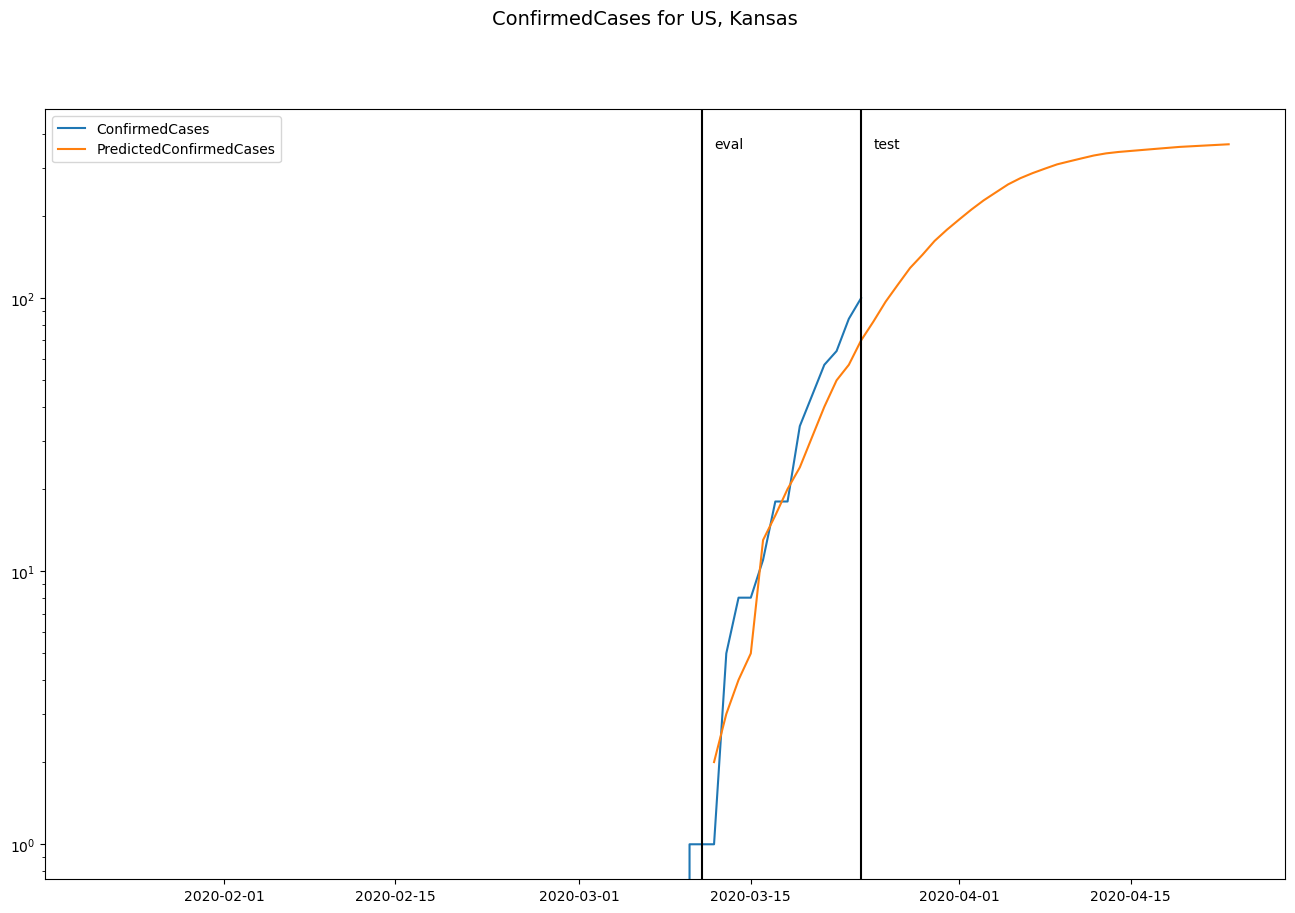

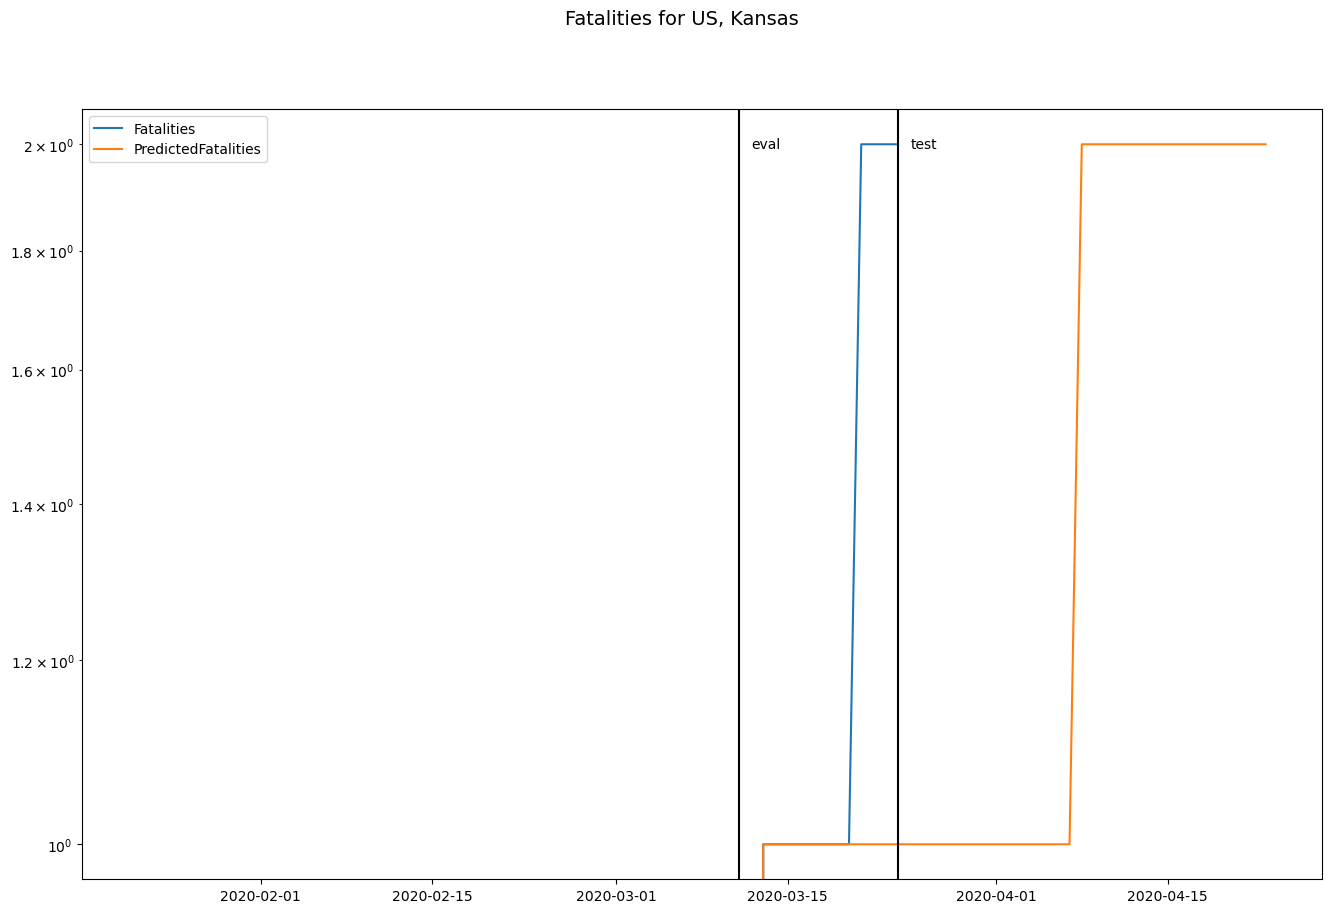

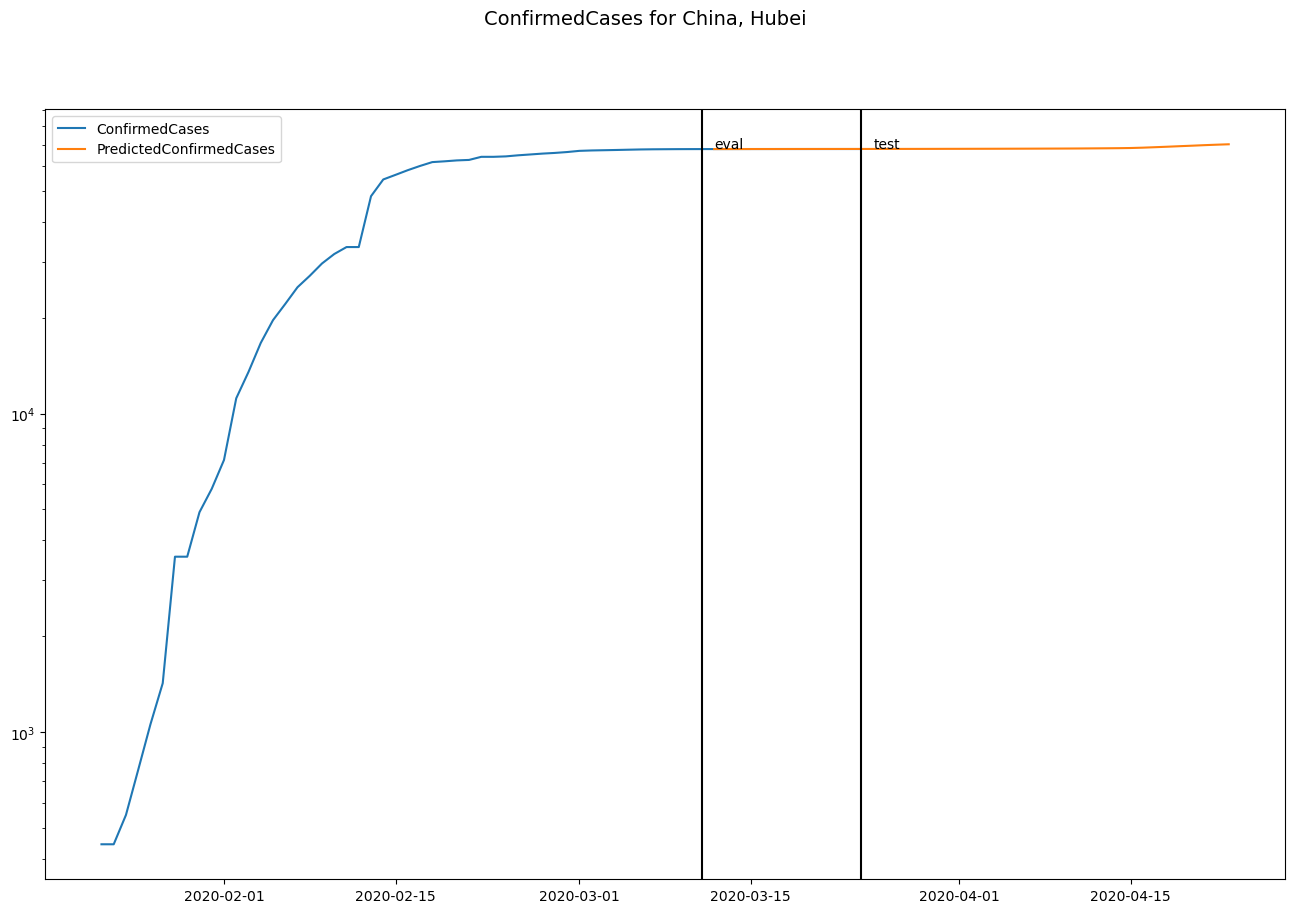

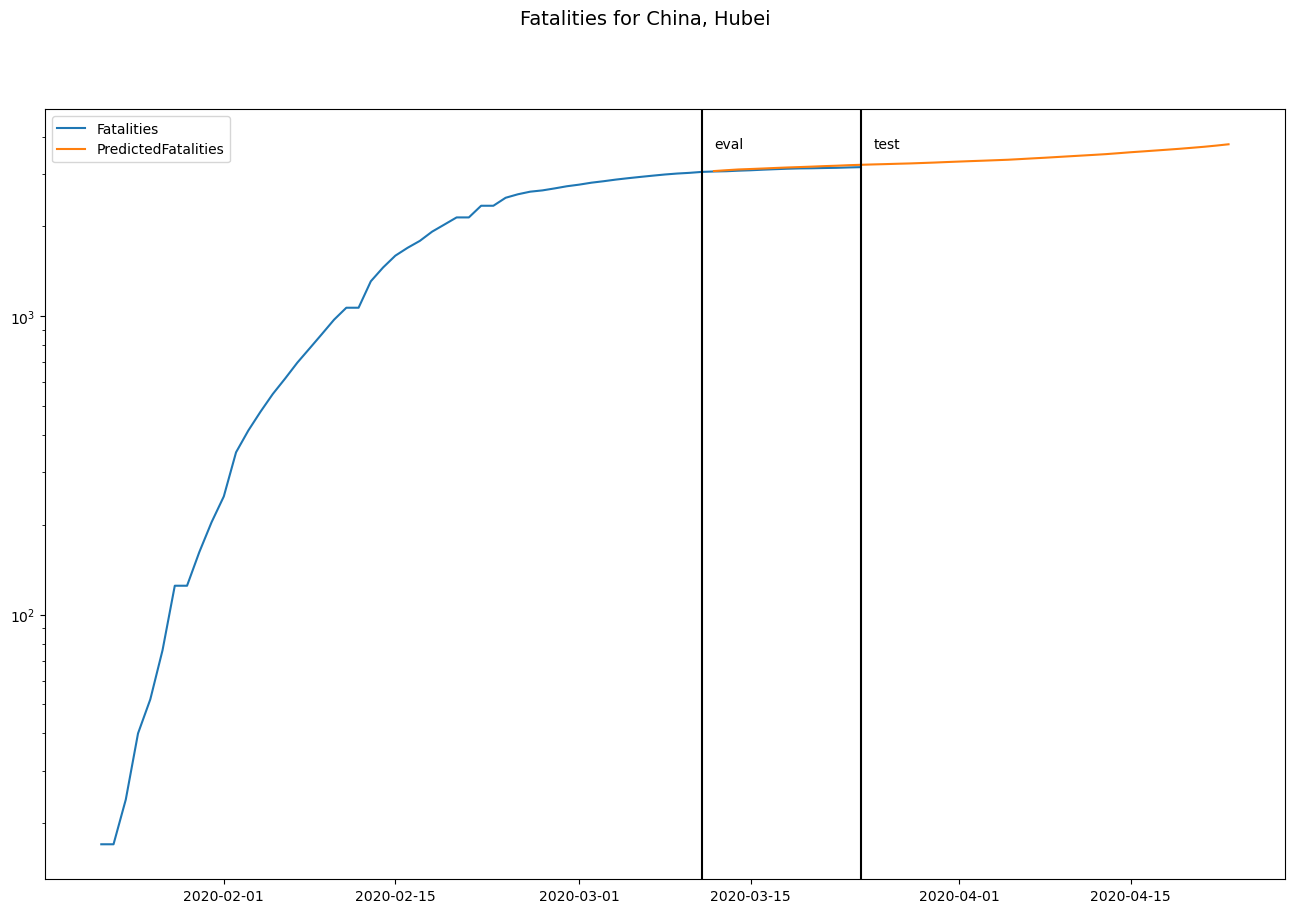

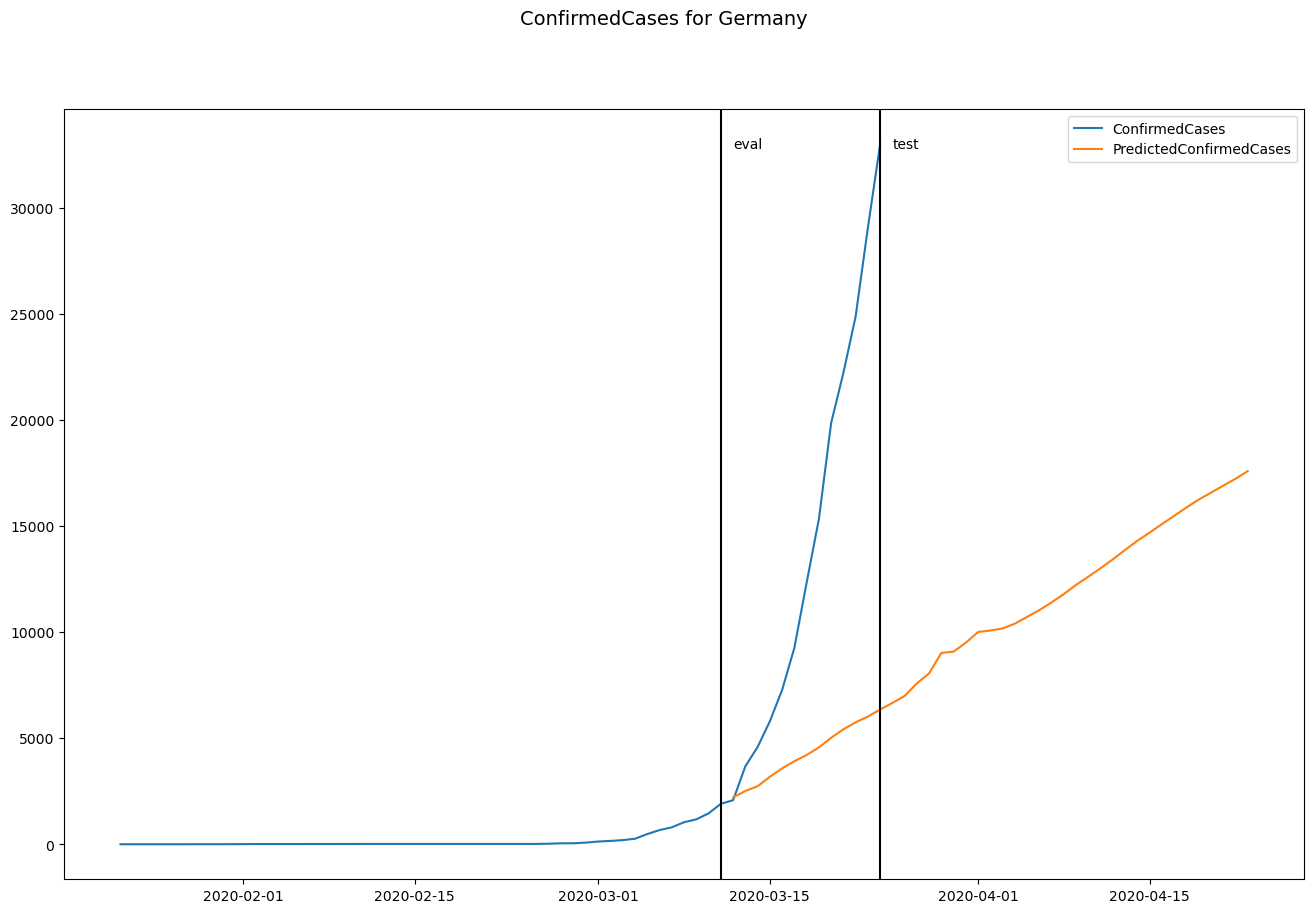

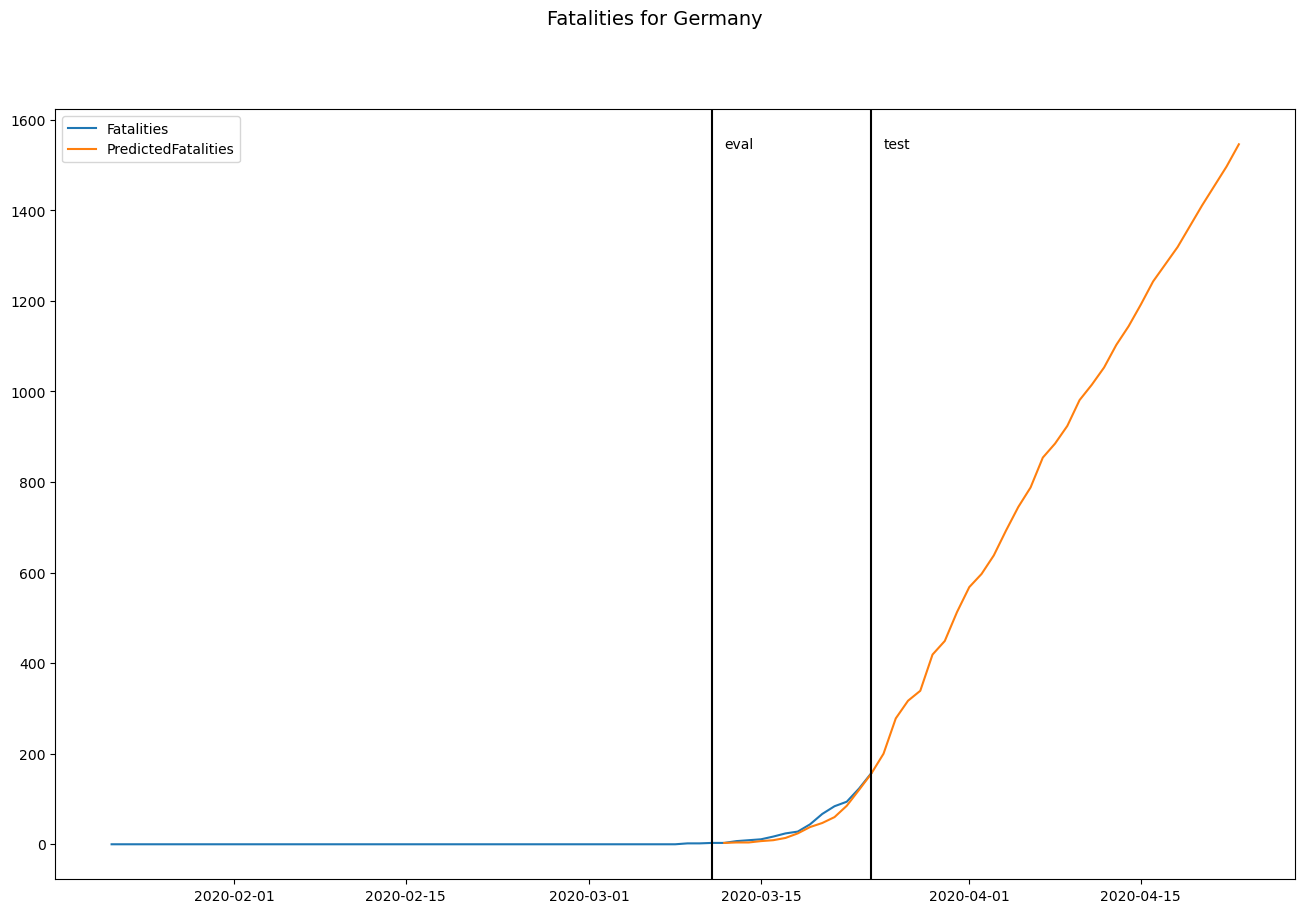

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib


def plot_graph(country_region, province_state, field, log_scale=True):
    location_df = main_df.loc[
        (main_df['Country/Region'] == country_region) & (main_df['Province/State'] == province_state)
    ]

    if province_state:
        title = '%s for %s, %s' % (field, country_region, province_state)
    else:
        title = '%s for %s' % (field, country_region)
    
    plt.figure(figsize = (16, 10))
    plt.suptitle(title, fontsize=14)
    if log_scale:
        plt.yscale('log')

    for sub_field in [field, 'Predicted' + field]:
        plt.plot(location_df['Date'], location_df[sub_field], label=sub_field)


    # add vertical lines splitting train, test and eval parts of the graph
    ax = plt.gca()

    # the x coords of this transformation are data, and the
    # y coord are axes
    transform_for_text = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)

    plt.axvline(x=last_train_date, color='#000000')
    plt.text(first_eval_date, 0.95, 'eval', transform = transform_for_text)
    plt.axvline(x=last_eval_date, color='#000000')
    plt.text(first_test_date, 0.95, 'test', transform = transform_for_text)


    plt.legend()
    plt.show()

plot_graph('US', 'Kansas', 'ConfirmedCases')
plot_graph('US', 'Kansas', 'Fatalities')
plot_graph('China', 'Hubei', 'ConfirmedCases')
plot_graph('China', 'Hubei', 'Fatalities')
plot_graph('Germany', '', 'ConfirmedCases', log_scale=False)
plot_graph('Germany', '', 'Fatalities', log_scale=False)